# EE219 Project 3

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181 *wyc20020111@ucla.edu*

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0 

surprise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', 
                       values='rating', fill_value=0).values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [2]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = len(r_data.rating.tolist())
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

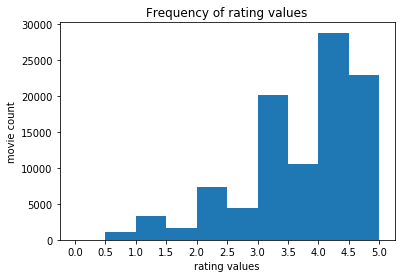

In [3]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

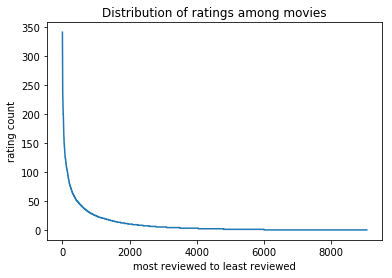

In [4]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(R, axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

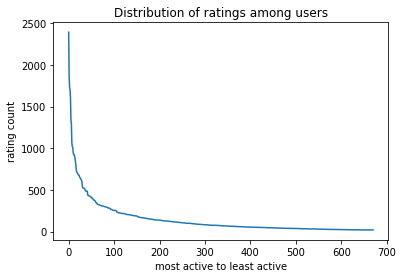

In [5]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(R, axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

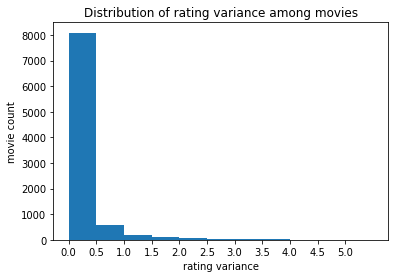

In [6]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.var(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()

#### Question 7

$I_u$ : Set of item indices for which ratings have been specifed by user $u$  
$I_v$ : Set of item indices for which ratings have been specifed by user $v$  
$\mu_u$ : Mean rating for user $u$ computed using her specifed ratings  
$r_{uk}$ : Rating of user $u$ for item $k$  

$$\mu_u = \frac{\Sigma_{i\in I_{u}} r_{ui}}{\mid I_u \mid}$$

#### Question 8

$I_{u} \cap I_{v}$ represents the indices of movies that are rated by both user $u$ and user $v$. It's possible that this intersection be the empty set ($\emptyset$), given the sparsity of the matrix. It happens when user $u$ has not rated any movie that user $v$ has.

#### Question 9

#### Question 10

In [7]:
import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
reader=Reader()
data = Dataset.load_builtin('ml-100k')

In [8]:
sim_options = {'name': 'pearson'}
rmselist=[]
maelist=[]

In [9]:
for i in range(2,101,2):
    algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=i, sim_options=sim_options)
    dict=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
    rmselist.append(np.mean(dict['test_rmse']))
    maelist.append(np.mean(dict['test_mae']))

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the p

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done com

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done com

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the p

Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done com

In [10]:
xaxis=range(2,101,2)

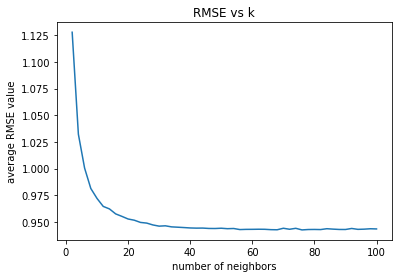

In [11]:
plt.plot(xaxis,rmselist)
plt.xlabel('number of neighbors')
plt.ylabel('average RMSE value')
plt.title('RMSE vs k')
plt.show()

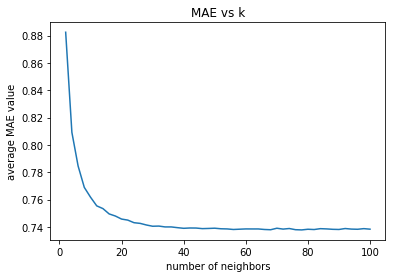

In [12]:
plt.plot(xaxis,maelist)
plt.xlabel('number of neighbors')
plt.ylabel('average MAE value')
plt.title('MAE vs k')
plt.show()

In [13]:
xaxis[5]

12

#### Question 11

In [14]:
# chose minimum k =12